# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span>
 Remember to check that it says the exact commit you should be working on </br>
 ### *This only needs to be run once, then the folder will be created*

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
%pip install .

c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


c:\Users\User\miniconda3\envs\absFreq33\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


HEAD detached at d9f785b
nothing to commit, working tree clean
Processing c:\users\user\msc_project\sus-optimization\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23543 sha256=8755cc54cfdaf218d058be4aa135b25c0986ea75f9058cb93a59d2bb8ba0e2c8
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\76\2b\f9\862133fb7ad25c2aad966eb13c8d8caeb255ceff7b9ed004ca
Successfully built susceptibility-to-fieldmap-fft
Note: you may need to restart the kernel to use updated packages.


In [2]:
home_path = "C:/Users/User/msc_project/sus-optimization"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\User\msc_project\sus-optimization


c:\Users\User\miniconda3\envs\absFreq33\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


README.md
__pycache__
chi_calculator.ipynb
chi_opt_absFreq_dB32.ipynb
chi_opt_absFreq_dB33.ipynb
chi_opt_multiple.ipynb
chi_opt_multiple_custom_dmod.ipynb
chi_opt_pro.ipynb
chi_opt_pro_dB33.ipynb
data
evas_code.ipynb
fixed_chi_test.ipynb
internal_air_only.nii.gz
output
requirements.txt
simulation
soothsayer.ipynb
spinal_cord_voxels_only.nii.gz
sus_optimization.ipynb
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [3]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

In [4]:
# Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# This function is only useful if you want to print and display while optimizing
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

## <span style="color:lime"> *Util functions used during the optimization process* </span> </br>
*Depracated*

In [4]:
# We need to reate the custom command that creates the fieldmap
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)

    # We need to return the data from the fieldmap created

    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)

    else:
        print("Fieldmap simulated correctly", result.stdout)
        sim_fm_img = nib.load(output_file)
        sim_fm_data = sim_fm_img.get_fdata()
        return sim_fm_data

In [7]:
#from utils.tools import chi_to_fm_ppm
# I believe this is unneeded, might delete laterxx

 # <span style="color:gold"> *Optimization begins!* </span> 

In [5]:
# First lets define the paths for simulation files
# Change run # to avoid mix of outputs per different optimization approach
path_to_iter_fms =  "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms"
path_to_iter_metrics =  "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics"
run_number = "run2_Powell"
path_to_iter_fms = os.path.join(path_to_iter_fms,run_number)
path_to_iter_metrics = os.path.join(path_to_iter_metrics,run_number)
counter = 0

########
# This don't change
path_to_sim_metric_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/B1_chi_maps/dB0_033_mod0.nii.gz" # -4.2ppm internal air (past value)
path_to_segs = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/final_merged_wb_segs.nii.gz"

In [6]:
path_to_avg_resp = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C1_meas/raw_avg_respiration.csv"
avg_resp_b0meas_metrics_csv = pd.read_csv(path_to_avg_resp)
avg_resp_b0meas_values = avg_resp_b0meas_metrics_csv["WA()"]
avg_resp_b0meas_values

0    -352.197815
1    -294.622358
2    -226.866665
3    -147.511515
4    -114.248745
5    -161.342531
6    -193.889314
7    -195.737893
8    -192.261237
9    -192.754594
10   -205.500094
Name: WA(), dtype: float64

In [7]:
vertebrae_levels = [ 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 4 to 14
# This is used paired with the data above. Peak @: T1

In [8]:
central_freq_db0_033 = 123.249489 # in MHz
gamma_bar = 42.58 # MHz/T
# If the central frequency from the scanner is 123.249489 MHz, it meas the B0 strenght we need to simulate is:
B0_used_scanner = central_freq_db0_033 /gamma_bar
print("The B0 to use in the simulation should be: ", B0_used_scanner, "T")

The B0 to use in the simulation should be:  2.8945394316580555 T


In [9]:
# For convergence plot testing
history = [] 

In [10]:
def f_iair_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Chi air : x[0] = {x[0]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_trachea = 0.1*(-9) + 0.9*(x[0])
    chi_lungs = 0.2*(-9) + 0.8*(x[0])

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi_air = x[0]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    chi_3_name = str(str(float(f"{chi_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving dmod FM... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run14 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1_name} & l: {chi2_name} & air: {chi_3_name}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [12]:
def f_iair_vol_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f"Iteration #{counter}")
    print(f"Chi internal air = 0.27")
    print(f"Vol_air Tr:  {x[0]}")
    print(f"Vol_air_lungs: {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Find indices with the labels we want to update
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_internal_air = 0.27 # ppm in SI units 
    chi_trachea = (1-x[0])*(-9) + (x[0])*(chi_internal_air)
    chi_lungs = (1-x[1])*(-9) + (x[1])*(chi_internal_air)

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50) #, mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * central_freq_db0_033
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    #chi_3_name = str(str(float(f"{chi_internal_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    #chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    #path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    #chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    #chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    #nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################
    sim_b0_Hz_name = f"sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    iter_fm_save_dir = os.path.join(path_to_iter_fms, sim_b0_Hz_name)
    sim_b0_Hz_img = nib.Nifti1Image(sim_b0_Hz, affine = sim_chi_img.affine )
    nib.save(sim_b0_Hz_img, iter_fm_save_dir)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics, metrics_name)



    extract_metrics(iter_fm_save_dir, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="4:14")

    metric_values = pd.read_csv(path_to_out_metrics)
    sim_fm_vert_values = metric_values['WA()'][::-1]
    
    # This is a test to see if chi value changes

    #crop_sim_values = dmod_sim_vert_values.iloc[[0,4,7]].values
    #print("### Sim Cropped:")
    #print(crop_sim_values)
    #print(type(crop_sim_values))
    #crop_meas_values = avg_resp_b0meas_values.iloc[[0,4,7]].values


    # Dunno how to have options in the objective fucntion so this if is manual lmao
    #if norm_type == "L2":
    difference_l2 = np.linalg.norm(avg_resp_b0meas_values - sim_fm_vert_values ) # This is the L2 norm
    difference = difference_l2
    print("Difference: ", difference)

    #crop_dif =  np.linalg.norm(crop_sim_values - crop_meas_values)
    #crop_dif = np.sum(np.abs(crop_sim_values)-np.abs(crop_meas_values))
    #print("Minimizing difference - L1 Norm: ", crop_dif)
    #difference = crop_dif
    #elif norm_type == "L1":
    #difference_L1 = np.sum(np.abs(avg_resp_b0meas_values)- np.abs(dmod_sim_vert_values))
    #difference =difference_L1
    #print("Minimizing difference - L1 Norm: ", difference_L1)

    vertebrae_levels =  [ 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, sim_fm_vert_values, marker = 'o', linestyle = '--', label = f"Simulated", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "In-vivo measured", color = "#264cff") 
    plt.title(f"$\\chi$ of trachea: {chi1_name} & Lung: {chi2_name} with Powell method")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-450, 0, 30)  
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()

# Trying to show convergence plot
    error = avg_resp_b0meas_values - sim_fm_vert_values
    loss = np.linalg.norm(error)
    history.append(loss)

    return difference

In [13]:
# Before running please verify your outpaths:
print(path_to_iter_fms)
print(path_to_iter_metrics)


E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell
E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell


In [14]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter


0

In [43]:
counter = 0
counter

0

 ### <span style="color:gold"> *Chi internal air!* </span> 

In *f_iair_vol_avg_resp_plot* : </br>
The internal value of chi is fixed to 0.27</br>
The second is the volume of trachea </br>
The third is the volume of lungs </br>
*Before running check if we use L1 or L2 norm, code auto-prints*

Creating run folders
Folders created:  E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell
$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #1
Chi internal air = 0.27
Vol_air Tr:  0.8
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-1_584_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_584_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_584_l_-4_365_Hz.csv


Difference:  670.0552919560414


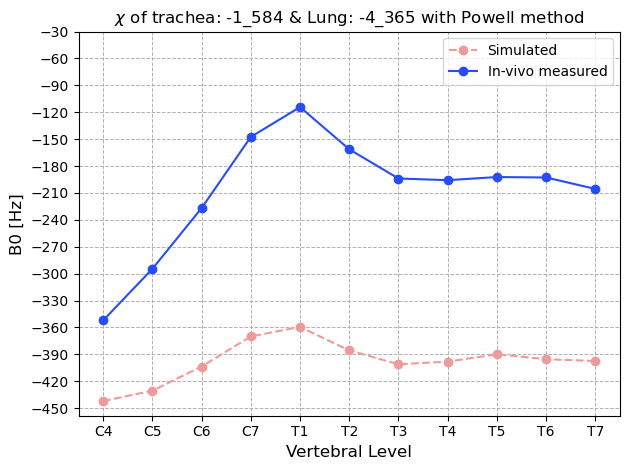

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #2
Chi internal air = 0.27
Vol_air Tr:  0.776393202250021
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-1_803_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_803_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_803_l_-4_365_Hz.csv


Difference:  670.0455184238534


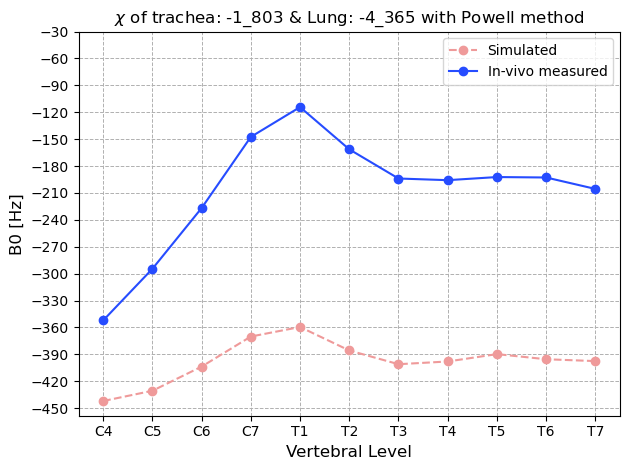

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #3
Chi internal air = 0.27
Vol_air Tr:  0.8236067977499789
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-1_365_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_365_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-1_365_l_-4_365_Hz.csv


Difference:  670.0652160261865


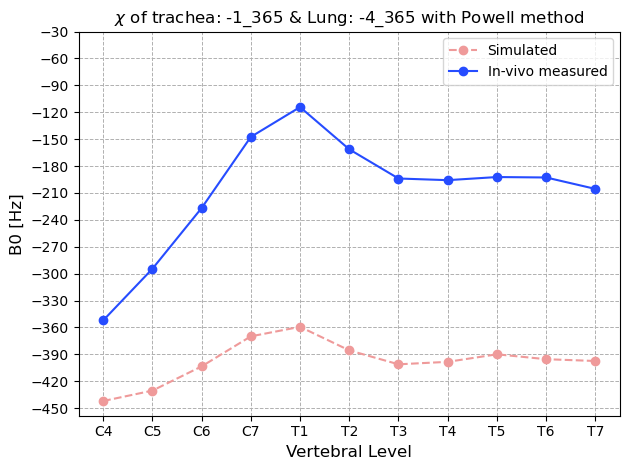

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #4
Chi internal air = 0.27
Vol_air Tr:  0.7472135954999579
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_073_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_073_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_073_l_-4_365_Hz.csv


Difference:  670.0336457218397


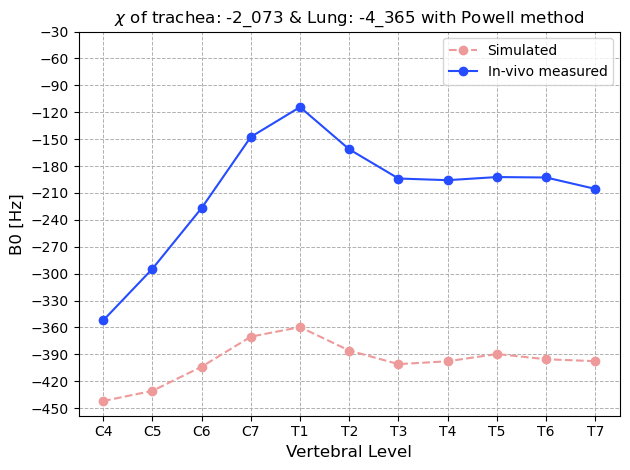

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #5
Chi internal air = 0.27
Vol_air Tr:  0.7291796067500631
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_241_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_241_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_241_l_-4_365_Hz.csv


Difference:  670.0264229995969


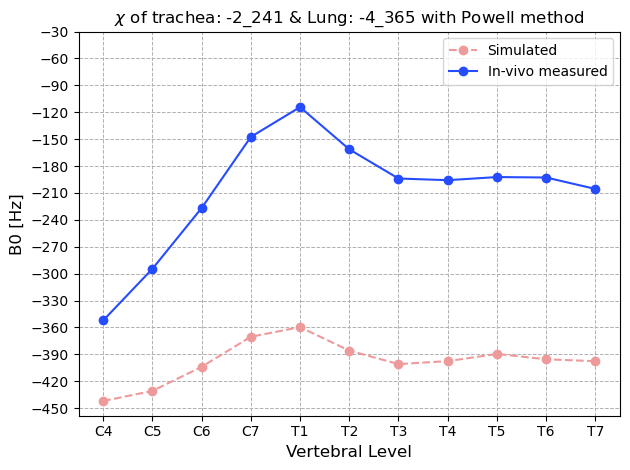

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #6
Chi internal air = 0.27
Vol_air Tr:  0.7180339887498948
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_344_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_344_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_344_l_-4_365_Hz.csv


Difference:  670.022003043643


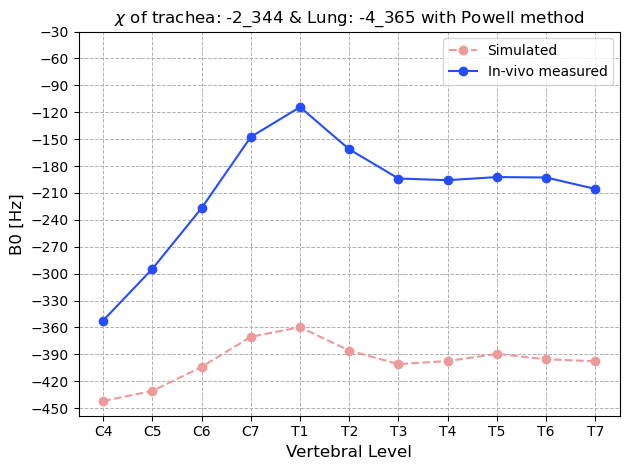

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #7
Chi internal air = 0.27
Vol_air Tr:  0.7111456180001682
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_408_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_408_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_408_l_-4_365_Hz.csv


Difference:  670.0192881414803


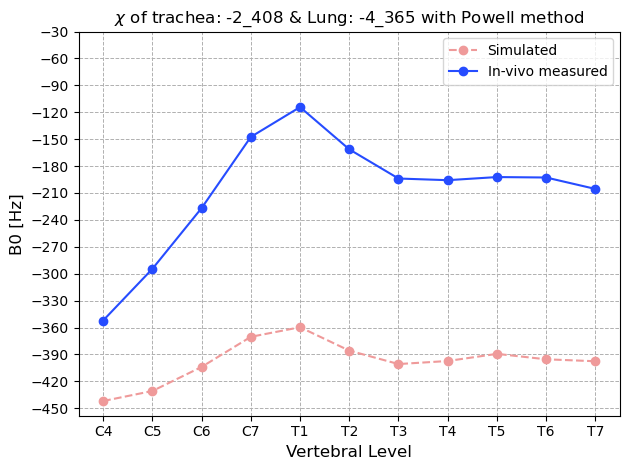

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #8
Chi internal air = 0.27
Vol_air Tr:  0.7068883707497265
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_447_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_447_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_447_l_-4_365_Hz.csv


Difference:  670.017616649464


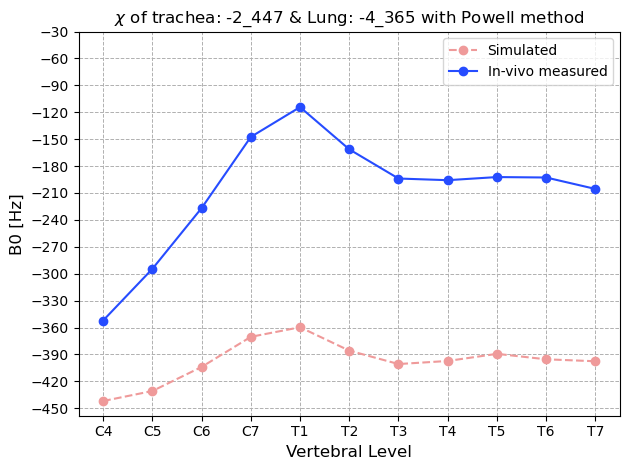

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #9
Chi internal air = 0.27
Vol_air Tr:  0.7042572472504416
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_472_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_472_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_472_l_-4_365_Hz.csv


Difference:  670.0165860589304


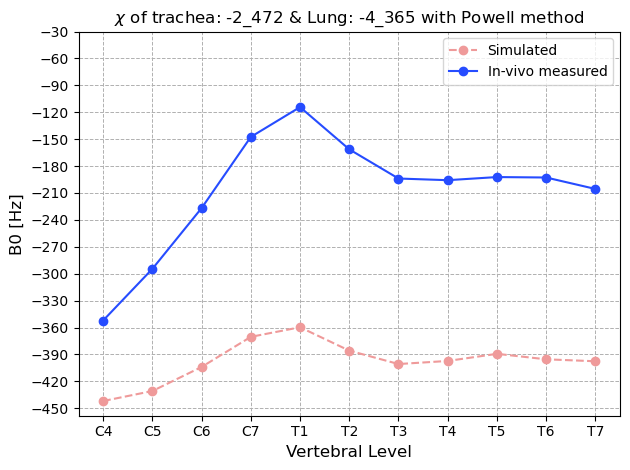

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #10
Chi internal air = 0.27
Vol_air Tr:  0.7026311234992849
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_487_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_487_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_487_l_-4_365_Hz.csv


Difference:  670.0159500541411


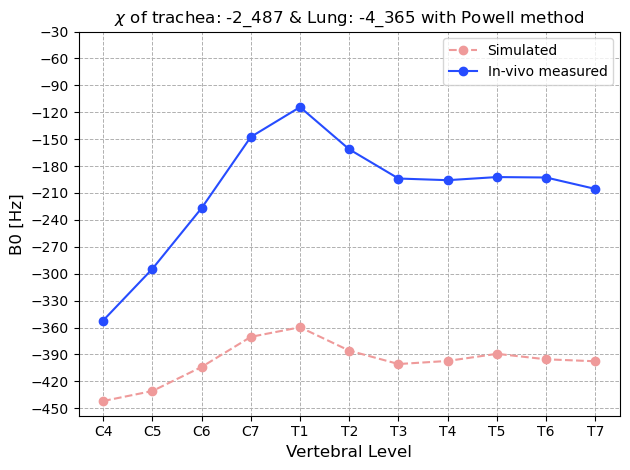

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #11
Chi internal air = 0.27
Vol_air Tr:  0.7016261237511566
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_496_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_496_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_496_l_-4_365_Hz.csv


Difference:  670.0155573387758


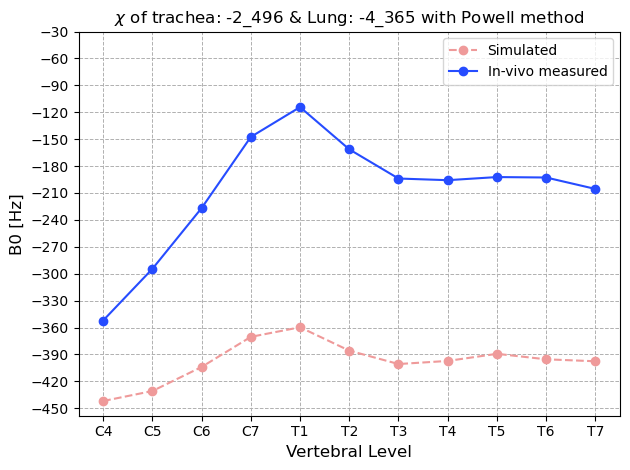

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #12
Chi internal air = 0.27
Vol_air Tr:  0.7010049997481282
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_502_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_502_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_502_l_-4_365_Hz.csv


Difference:  670.0153147637749


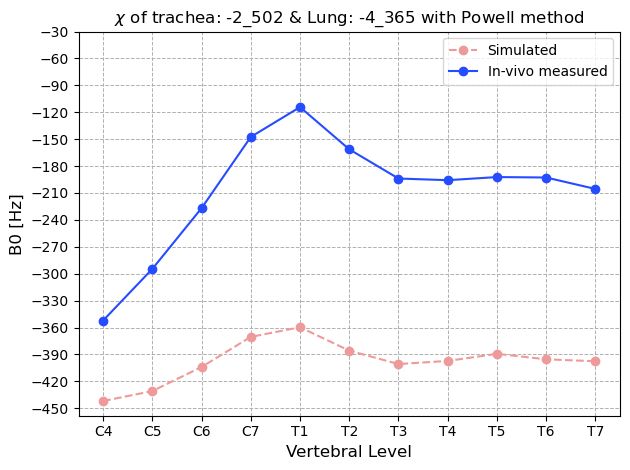

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #13
Chi internal air = 0.27
Vol_air Tr:  0.7006211240030283
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_505_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_505_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_505_l_-4_365_Hz.csv


Difference:  670.0151648962961


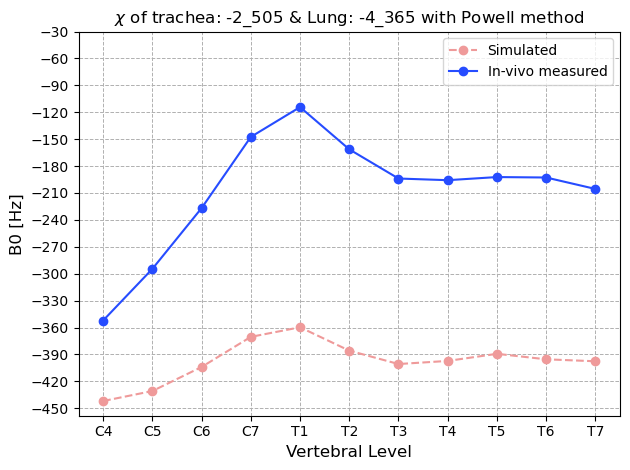

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #14
Chi internal air = 0.27
Vol_air Tr:  0.7003838757450999
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_507_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_507_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_507_l_-4_365_Hz.csv


Difference:  670.0150722930076


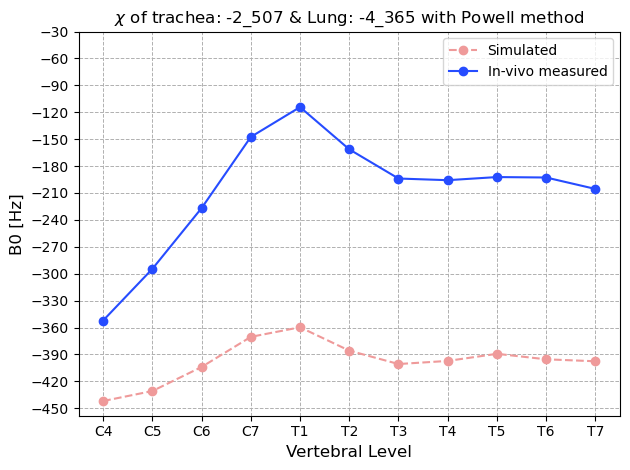

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #15
Chi internal air = 0.27
Vol_air Tr:  0.7002372482579284
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_509_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_509_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_509_l_-4_365_Hz.csv


Difference:  670.0150150686311


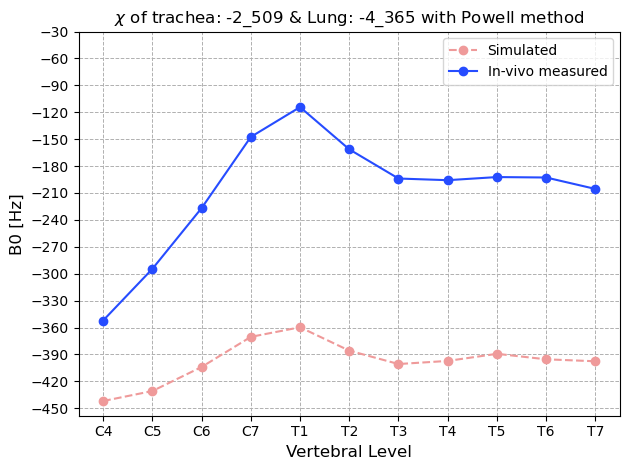

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #16
Chi internal air = 0.27
Vol_air Tr:  0.7001466274871715
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv


Difference:  670.0149797049261


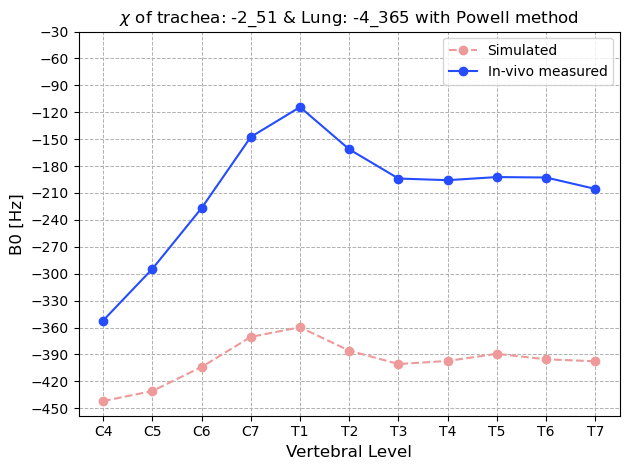

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #17
Chi internal air = 0.27
Vol_air Tr:  0.7000906207707569
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv


Difference:  670.0149578500636


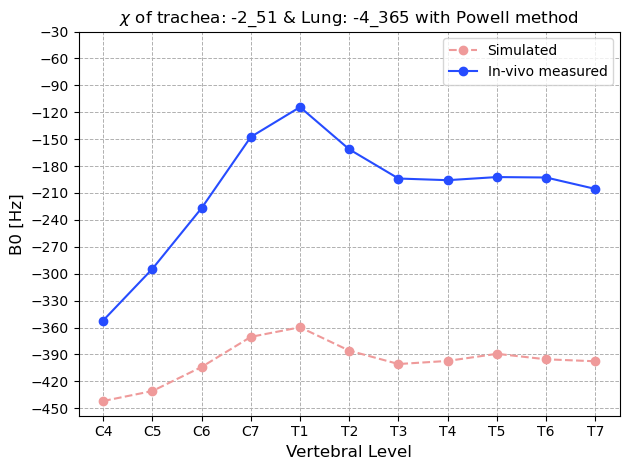

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #18
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.5
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-4_365_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_365_Hz.csv


Difference:  670.0149443434397


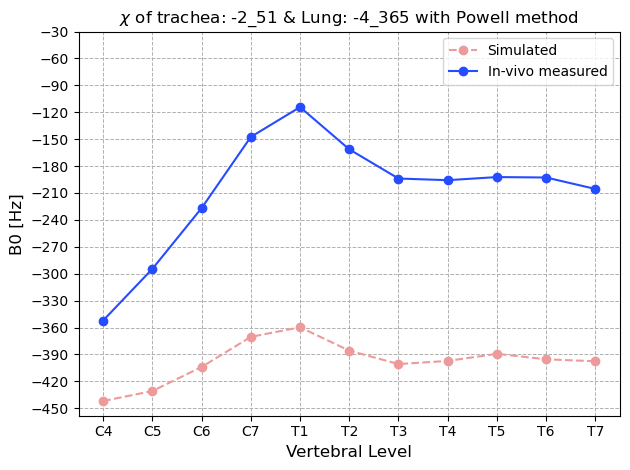

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #19
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.49098300562505254
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-4_449_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_449_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-4_449_Hz.csv


Difference:  669.6440997523104


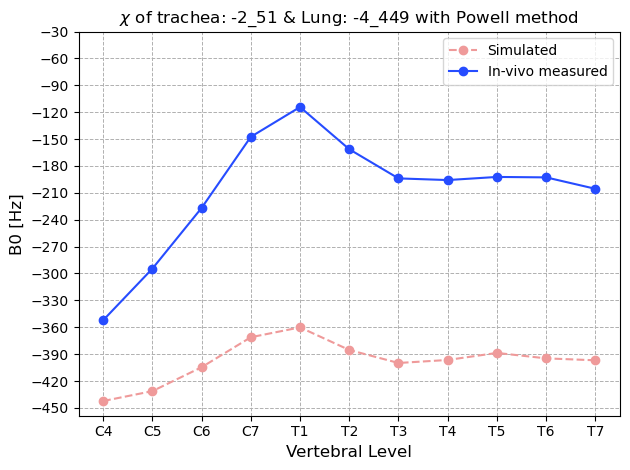

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #20
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.6090169943749474
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-3_354_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-3_354_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-3_354_Hz.csv


Difference:  675.0026078648445


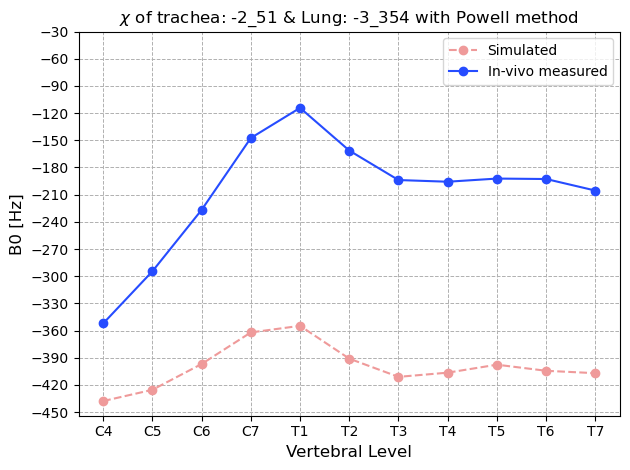

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #21
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.41803398874989484
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-5_125_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_125_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_125_Hz.csv


Difference:  666.8809494529611


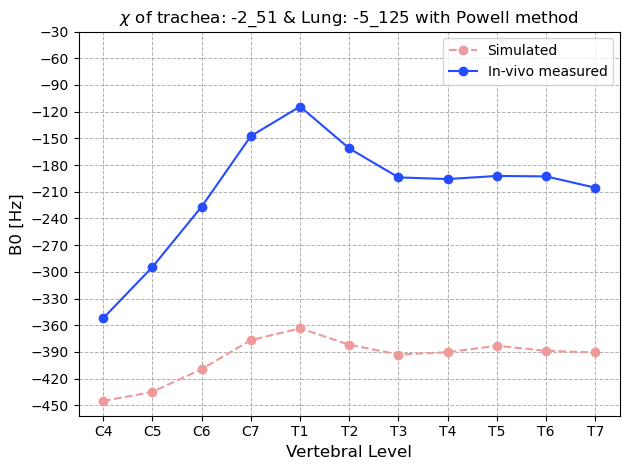

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #22
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3729490168751577
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-5_543_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_543_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_543_Hz.csv


Difference:  665.3856940305525


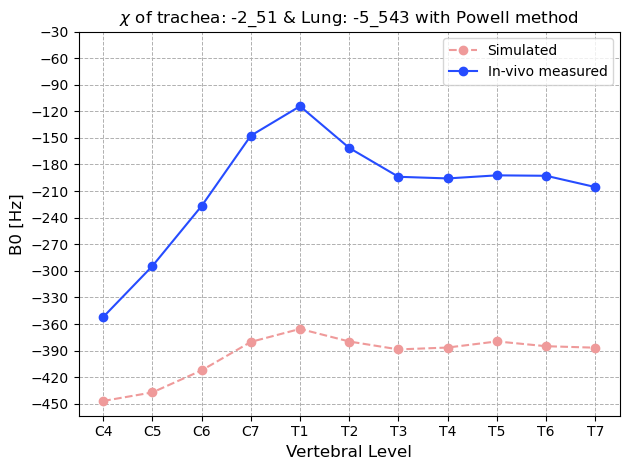

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #23
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3450849718747371
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-5_801_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_801_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_801_Hz.csv


Difference:  664.5433368586189


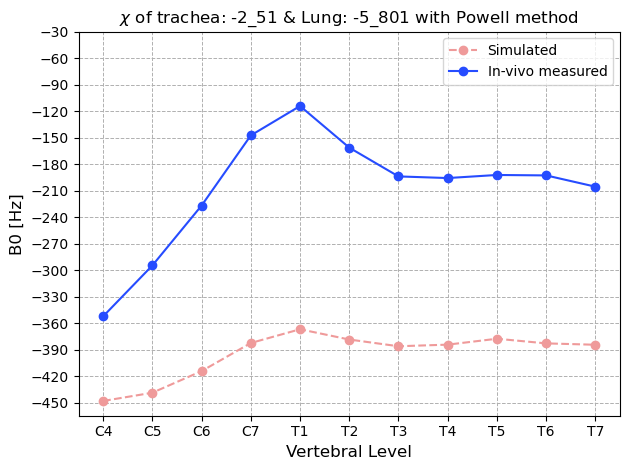

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #24
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3278640450004206
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-5_961_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_961_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-5_961_Hz.csv


Difference:  664.0540921853976


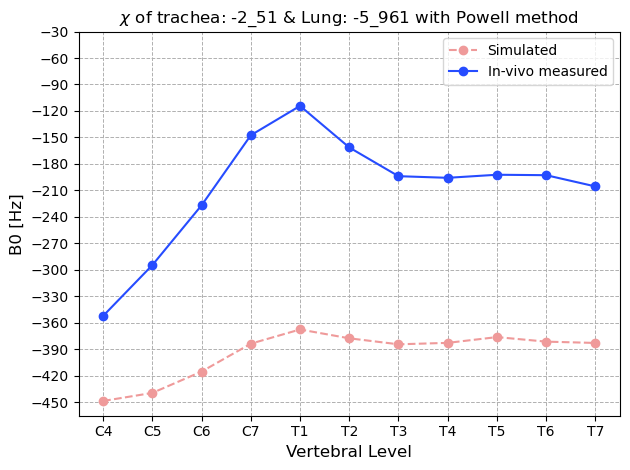

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #25
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.31722092687431647
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_059_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_059_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_059_Hz.csv


Difference:  663.7637299878614


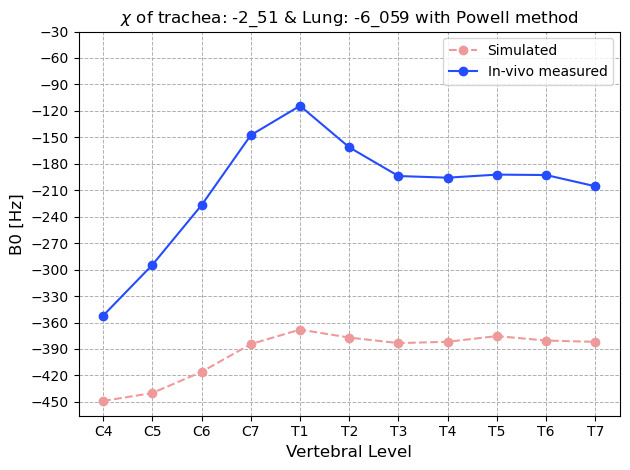

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #26
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.31064311812610407
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_12_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_12_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_12_Hz.csv


Difference:  663.5888693365566


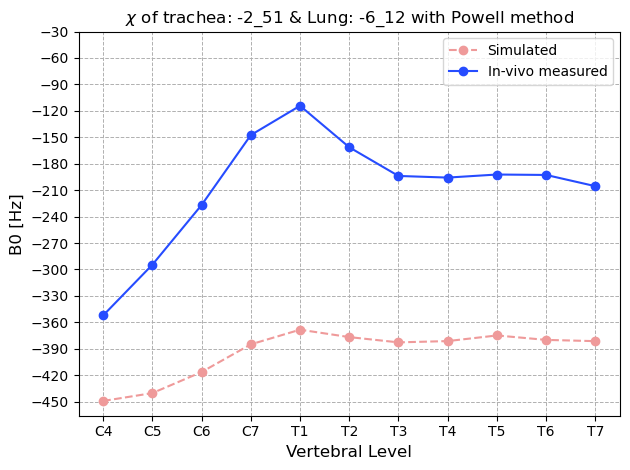

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #27
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3065778087482124
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_158_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_158_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_158_Hz.csv


Difference:  663.4825554057311


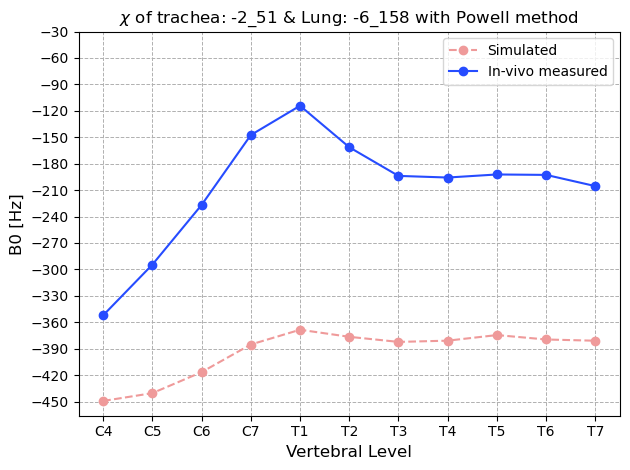

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #28
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.30406530937789167
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_181_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_181_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_181_Hz.csv


Difference:  663.4175208241121


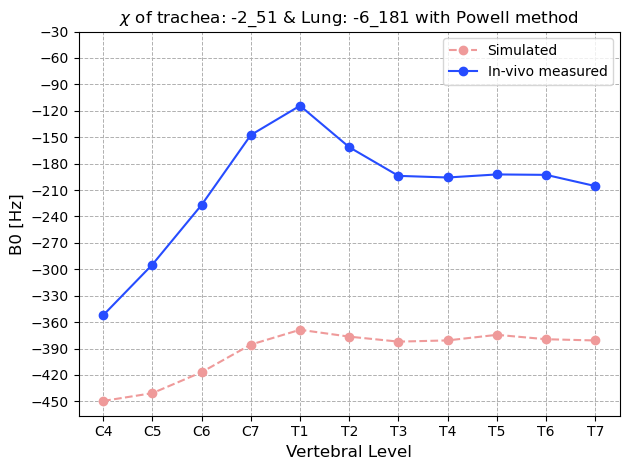

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #29
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3025124993703207
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_196_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_196_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_196_Hz.csv


Difference:  663.3775836385994


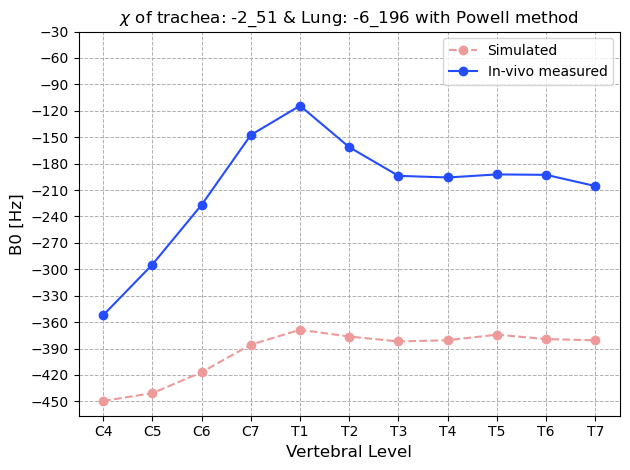

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #30
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.3015528100075709
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_fms\run2_Powell\sim_fm_tr_-2_51_l_-6_205_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 4:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_205_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt2/iteration_metrics\run2_Powell\metrics_sim_fm_tr_-2_51_l_-6_205_Hz.csv


Difference:  663.3529990543406


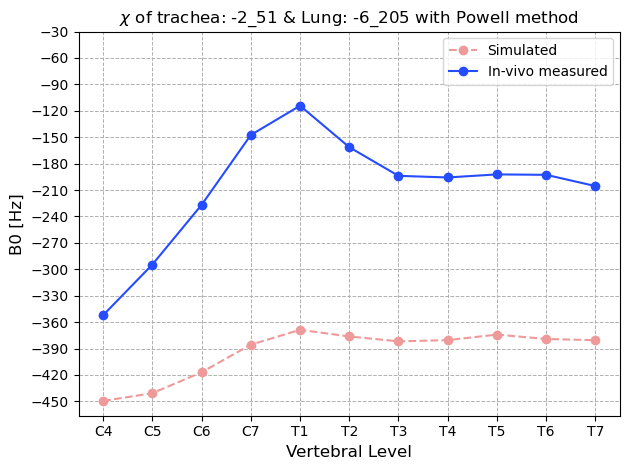

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #31
Chi internal air = 0.27
Vol_air Tr:  0.7000560067164144
Vol_air_lungs: 0.30095968936274975


KeyboardInterrupt: 

In [ ]:
# Set initial values, boundaries and run optimization
initial_values = [0.8, 0.5] # Body should begin
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(0.7, 0.9), (0.3, 0.8)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_fms)
    
    result = optimize.minimize(f_iair_vol_avg_resp_plot, initial_values, bounds = bounds, method = 'Powell')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")

    plt.figure()
    chi_values_range = np.linspace(-1, 0.5, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(history, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Convergence Plot 1D for Chi Air")
    plt.grid()
    plt.show()

<Figure size 640x480 with 0 Axes>

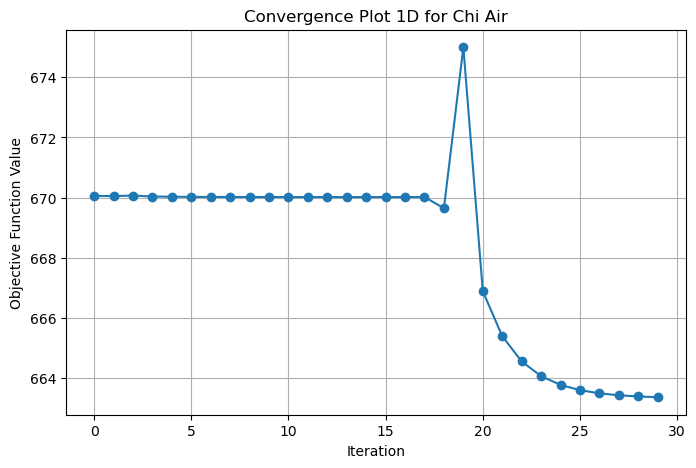

In [16]:
# Plotting after interruption
# Interrupted the solver due to objective function to far for the solver
# No realistic susceptibility change will shorten the distance from the curves
# We still need to check why this happens
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence Plot 1D for Chi Air")
plt.grid()
plt.show()

In [89]:
os.path.exists(path_to_iter_dmod_fms)

True

# <span style="color:chocolate"> *Plot and compare!* </span> 

In [42]:
# Load specific metrics by name, from output log
run2_iter20 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-5_16_l_-0_389_Hz.csv")
run2_iter20_values = run2_iter20["WA()"]
run2_iter20_values = run2_iter20_values[::-1]

In [54]:
run4_last_iter = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run4/metrics_sim_fm_tr_-5_0_l_-0_575_Hz.csv")
run4_last_iter_vals = run4_last_iter["WA()"]
run4_last_iter_vals = run4_last_iter_vals[::-1]

In [70]:
# One with x lung far from that range
run6 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run6/metrics_sim_fm_tr_-2_0_l_1_0_Hz.csv")
run6_values = run6["WA()"][::-1]

In [106]:
run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7/metrics_sim_fm_tr_-2_0_l_0_0_Hz.csv")
run7_values = run7["WA()"][::-1]
run7_values

12   -179.632875
11   -142.424619
10    -76.976387
9      -0.345025
8      93.837069
7      89.462894
6       7.859834
5     -26.918593
4      -4.591906
3      32.335572
2      53.256685
1      41.671918
0      39.592175
Name: WA(), dtype: float64

In [107]:
first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")
first_run7_vals = first_run7["WA()"][::-1]
first_run7_vals

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_49552\3367052066.py:1: SyntaxWarning: invalid escape sequence '\m'
  first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")


12   -219.740118
11   -189.120055
10   -135.339877
9     -74.304475
8      13.790056
7      51.663695
6      43.468552
5      41.938307
4      59.908588
3      84.494172
2     100.697910
1      91.271720
0      81.204982
Name: WA(), dtype: float64

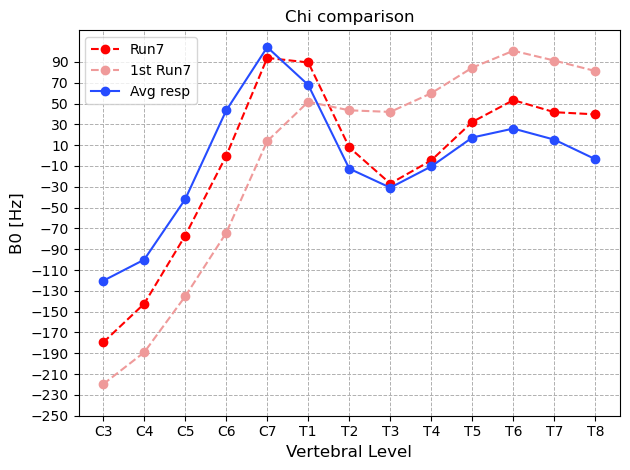

In [121]:
# We already have the cervical level and measured, 
# Copy the last (or any) fm metric name from SCT result

#final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics\metrics_sim_fm_tr_-14_0_l_-0_277_Hz.csv")
final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-9_0_l_-0_443_Hz.csv")

dmod_sim_vert_values = final_dmod["WA()"]
dmod_sim_vert_values = dmod_sim_vert_values[::-1]

vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 3 to 15


#plt.plot(vertebrae_levels, dmod_b0meas_vert_values, marker = 'x', linestyle = '-', label = "Measured Exp", color = "#ff4900") 
#plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = "Run1", color = "#33C3FF") 
#plt.plot(vertebrae_levels, run6_values, marker = 'o', linestyle = '--', label = "Run6", color = "#FBC02D") 
plt.plot(vertebrae_levels, run7_values, marker = 'o', linestyle = '--', label = "Run7", color = "red") 
plt.plot(vertebrae_levels, first_run7_vals, marker = 'o', linestyle = '--', label = "1st Run7", color = "#EF9A9A") 
#plt.plot(vertebrae_levels, run4_last_iter_vals, marker = 'o', linestyle = '--', label = "Run4", color = "#81C784") 
plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 

# Adding expiration and inspiration measured values
#plt.plot(vertebrae_levels, exp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Expiration B0 measured", color = "#ff4900")
#plt.plot(vertebrae_levels, insp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Inspiration B0 measured", color = "#ffad00")
#plt.plot(vertebrae_levels, avg_respiration, marker = 'o', linestyle = ':', label = "Avg respiratin B0 meas", color = "#264cff")
plt.title("Chi comparison")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()

yticks = range(-250, 101, 20) 
plt.yticks(yticks)


# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [2]:
dir ()

['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'open',
 'quit']